In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import scipy.io as sio
import scipy.misc as sm
import tensorflow as tf

from tensorflow.python.platform import gfile

from utils import *

sess = tf.InteractiveSession()

In [3]:
def imread(path):
    return sm.imread(path).astype(np.float)

mat_path = "./imagenet-vgg-verydeep-19.mat"
mat = sio.loadmat(mat_path)

def build_conv2d(w, b):
    def make_layer(input):
        conv = tf.nn.conv2d(input, w, strides=[1,1,1,1], padding='SAME')
        return tf.nn.bias_add(conv, b.reshape(-1))
    return make_layer

def build_pool():
    def make_layer(input):
        return tf.nn.max_pool(input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return make_layer

layer_tags = [
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
    'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2',
    'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv4_2', 'relu5_2',
    'conv5_3', 'relu5_3', 'conv4_4', 'relu5_4'
]

mean = mat['normalization'][0][0][0] # (224, 224, 3)
mean_pixel = np.mean(mean, axis=(0,1))

def normalize(image):
    return image - mean_pixel

def unnormalize(image):
    return image + mean_pixel

# mat['layers'] : [1 x 43]
constants = mat['layers'][0]

x = tf.placeholder(tf.float32, [None, None, None, None])

layers = []
for idx, tag in enumerate(layer_tags):
    if 'conv' in tag:
        w = np.transpose(constants[idx][0][0][0][0][0], (1, 0, 2, 3))
        op = build_conv2d(w, constants[idx][0][0][0][0][1])
    elif 'relu' in tag:
        op = tf.nn.relu
    elif 'pool' in tag:
        op = build_pool()
    else:
        print("[!] Error: %s not found" % tag)

    if layers:
        layers.append(op(layers[-1]))
    else:
        layers.append(op(x))

image_path = os.path.join('./', 'test.png')
if not os.path.isfile(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
image_data = imread(image_path)

sess = tf.InteractiveSession()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11128dd10>> ignored


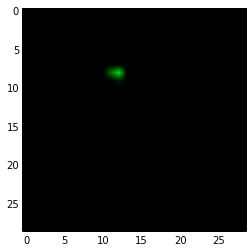

In [4]:
norm_image = normalize(image_data)
result = sess.run(layers[-1], feed_dict={x: [norm_image]})
plt.imshow(result[0,:,:,:3])
#plt.imshow(unnormalize(result[0,:,:,:3]))

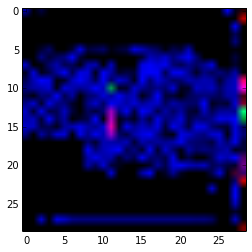

In [5]:
norm_image = normalize(image_data)
result = sess.run(layers[-3], feed_dict={x: [norm_image]})
plt.imshow(result[0,:,:,:3])

#plt.imshow(unnormalize(result[0,:,:,:3]))

In [6]:
image_data.shape

(460, 460, 3)

In [9]:
norm_image = normalize(image_data)

feature_map = {}
for idx, tag in enumerate(layer_tags):
    result = sess.run(layers[idx], feed_dict={x: [norm_image]})
    feature_map[idx] = result

layers_ = []
losses = []

x_ = tf.Variable(tf.random_normal([1] + list(image_data.shape), mean=0.0, stddev=1.0))

for idx, tag in enumerate(layer_tags):
    if 'conv' in tag:
        w = np.transpose(constants[idx][0][0][0][0][0], (1, 0, 2, 3))
        op = build_conv2d(w, constants[idx][0][0][0][0][1])
    elif 'relu' in tag:
        op = tf.nn.relu
    elif 'pool' in tag:
        op = build_pool()
    else:
        raise("Error: %s not found" % tag)

    if layers_:
        layer_ = op(layers_[-1])
    else:
        layer_ = op(x_)
    
    loss = 2 * tf.nn.l2_loss(feature_map[idx] - layer_) / feature_map[idx].size

    layers_.append(layer_)
    losses.append(loss)

In [13]:
def get_idx_with_name(name):
    return layer_tags.index(name)

In [16]:
epoch_size = 10000

idx = get_idx_with_name('conv4_1')

loss = losses[idx]
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

init = tf.initialize_all_variables()
sess.run(init)

for epoch in xrange(epoch_size):
    sess.run(train)
    
    if epoch % 100 == 0:
        print sess.run(loss)

2.15467e+06
2.00208e+06
1.88297e+06
1.77186e+06


KeyboardInterrupt: 

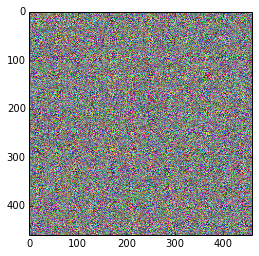

In [19]:
result = x_.eval()
plt.imshow(result[0])